## Human Activity Recognition from accelerometer data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
datafolder='Activity_Recognition_from Single_Chest-Mounted_Accelerometer/'
person={}
for i in range(15):
    person[i+1]= pd.read_csv(datafolder+str(i+1)+'.csv',index_col=0,names=['seq num', 'ax', 'ay', 'az', 'label']) 

In [3]:
for i in person:
    print(i,'shape:',person[i].shape)#,'columns:',person[i].columns)

1 shape: (162501, 4)
2 shape: (138001, 4)
3 shape: (102341, 4)
4 shape: (122201, 4)
5 shape: (160001, 4)
6 shape: (140901, 4)
7 shape: (163001, 4)
8 shape: (138001, 4)
9 shape: (166741, 4)
10 shape: (126801, 4)
11 shape: (104451, 4)
12 shape: (114702, 4)
13 shape: (67651, 4)
14 shape: (116101, 4)
15 shape: (103501, 4)


In [4]:
person[1].iloc[99995:100010]

,ax,ay,az,label
seq num,,,,
99995.0,1918,2385,1991,7
99996.0,1914,2390,1989,7
99997.0,1912,2386,1993,7
99998.0,1913,2379,1997,7
99999.0,1914,2386,1993,7
100000.0,1914,2383,1987,7
100000.0,1911,2384,1990,7
100000.0,1913,2385,1993,7
100000.0,1917,2389,1990,7


In [5]:
person[2][person[2]['label']==0].head()

,ax,ay,az,label
seq num,,,,
104300.0,2143,2339,1959,0
104300.0,2146,2341,1960,0
104300.0,2144,2338,1959,0
104300.0,2145,2340,1964,0
104300.0,2145,2340,1957,0


In [6]:
class_dict={}
class_dict[1]='Working at Computer'
class_dict[2]='Standing Up, Walking and Going Up/Down stairs' 
class_dict[3]='Standing'
class_dict[4]='Walking'
class_dict[5]='Going Up/Down Stairs'
class_dict[6]='Walking and Talking with Someone'
class_dict[7]='Talking while Standing'

In [7]:
def plot_data(folder='raw'):
    os.system('mkdir -p plots/'+folder)
    for i in person:

        fig, ax = plt.subplots(4,1, figsize=(6.4*1.5,4.8*1.5),sharex='col') 

        ax[0].plot(person[i]['ax'])
        ax[0].set_ylabel('ax')

        ax[1].plot(person[i]['ay'])
        ax[1].set_ylabel('ay')

        ax[2].plot(person[i]['az'])
        ax[2].set_ylabel('az')

        ax[3].plot(person[i]['label'])
        ax[3].set_ylabel('label')

        fig.suptitle('person '+str(i))

        fig.savefig('plots/'+folder+'/'+'person'+str(i))
        
        
def normalize_data(dataset):
    dataset = dataset - dataset.mean()
    dataset = dataset/dataset.std()
    return dataset


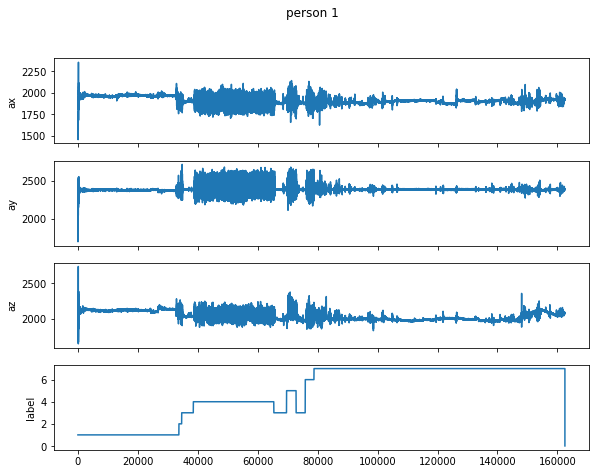

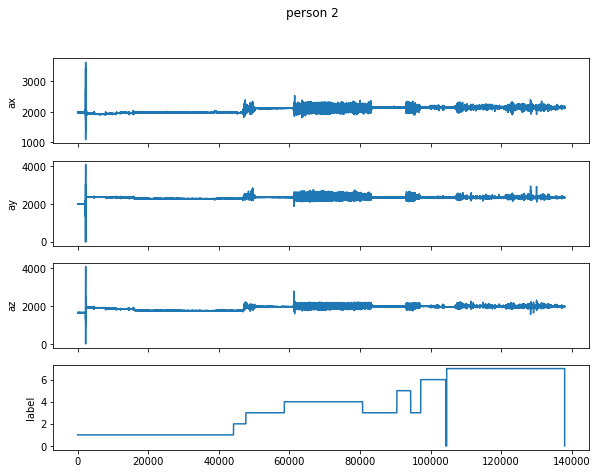

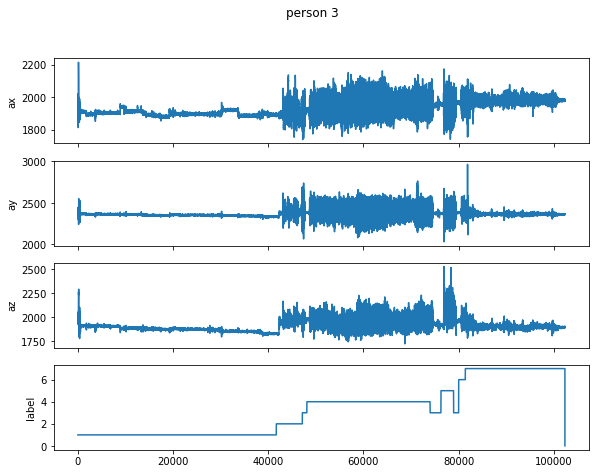

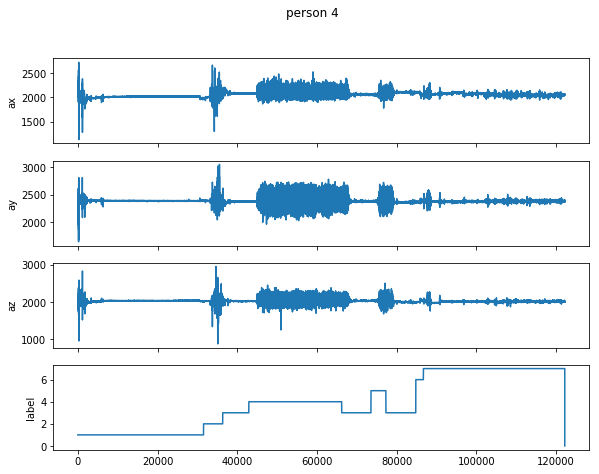

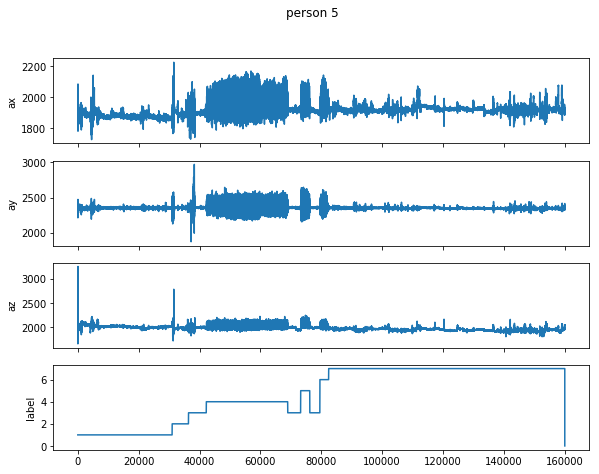

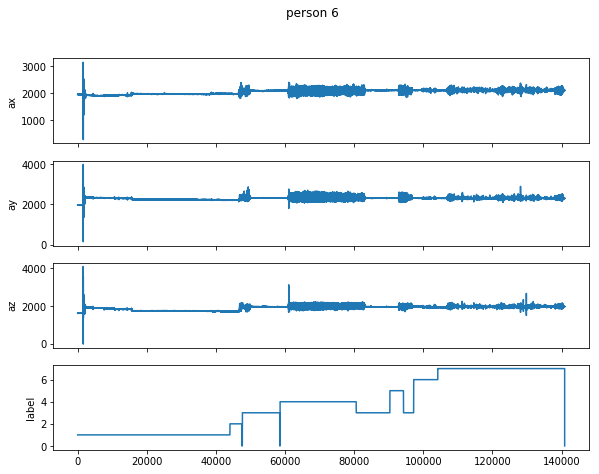

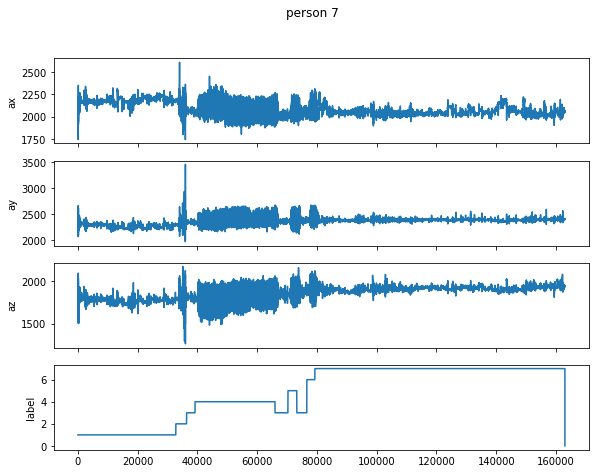

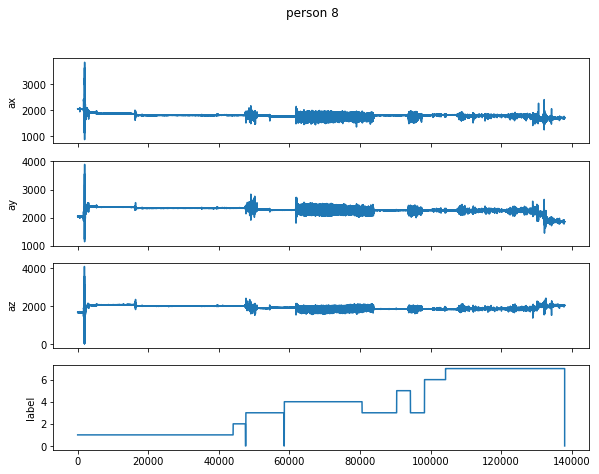

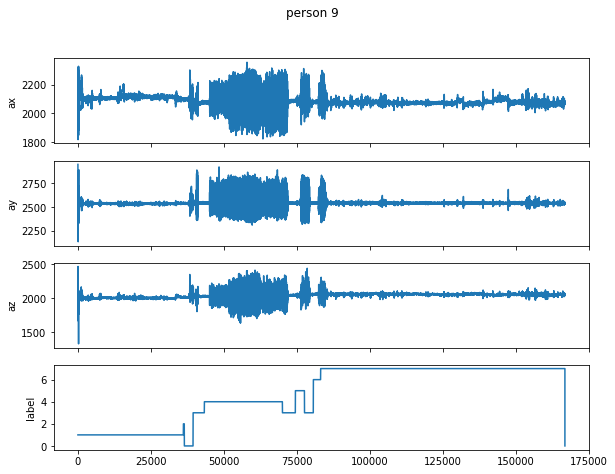

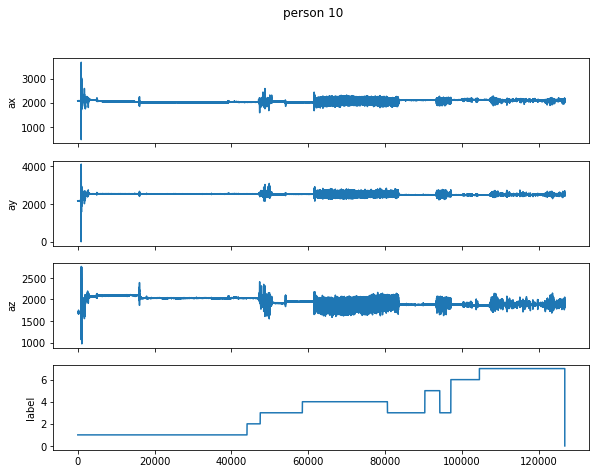

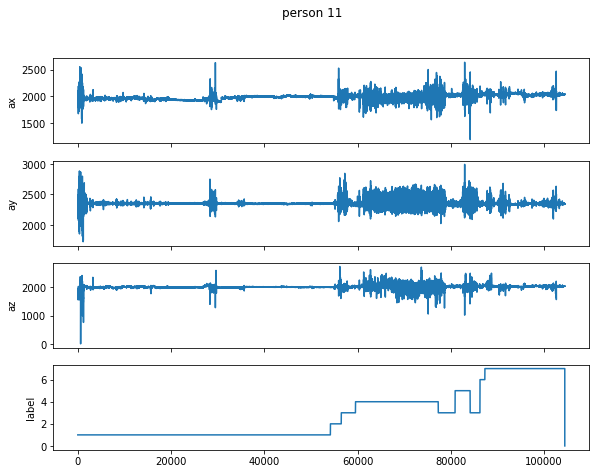

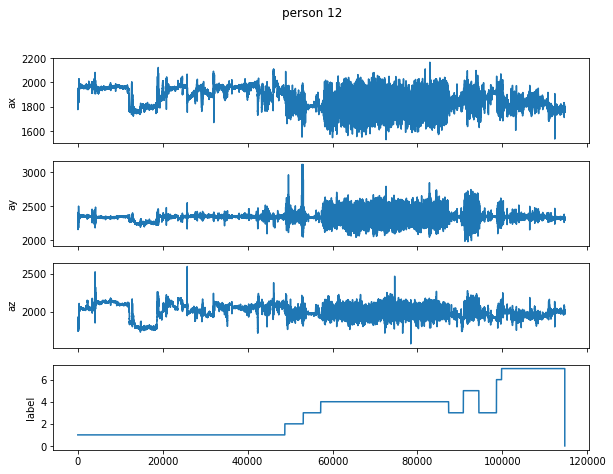

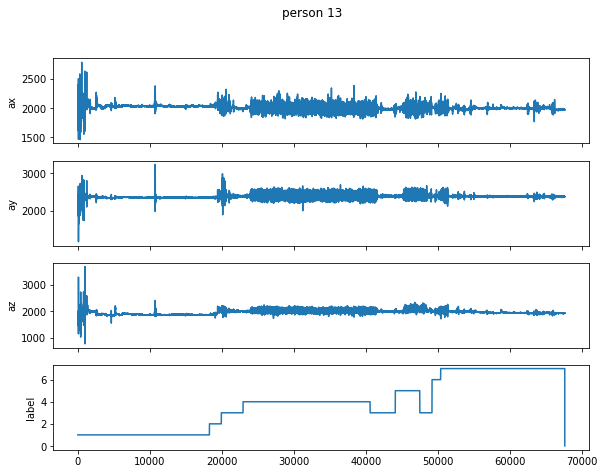

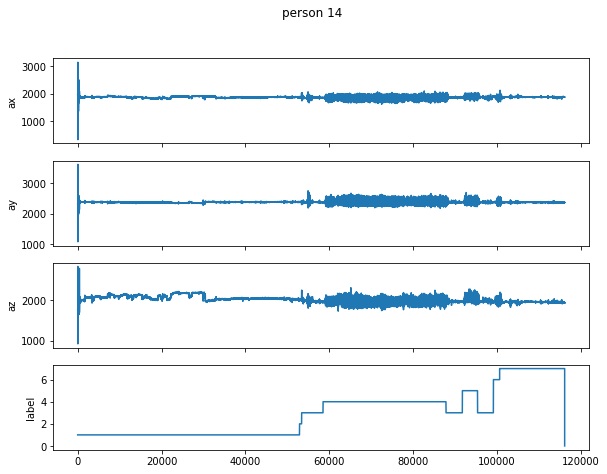

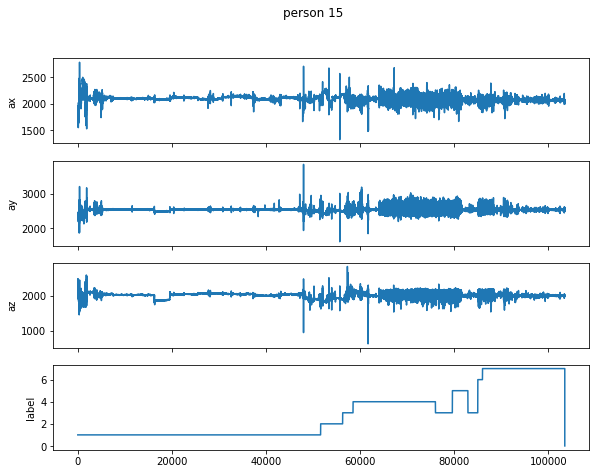

In [8]:
plot_data('raw')

In [9]:
# Remove entries with label=0
for i in person:
    index_to_drop = person[i][person[i]['label']==0].index
    person[i] = person[i].drop(index_to_drop)

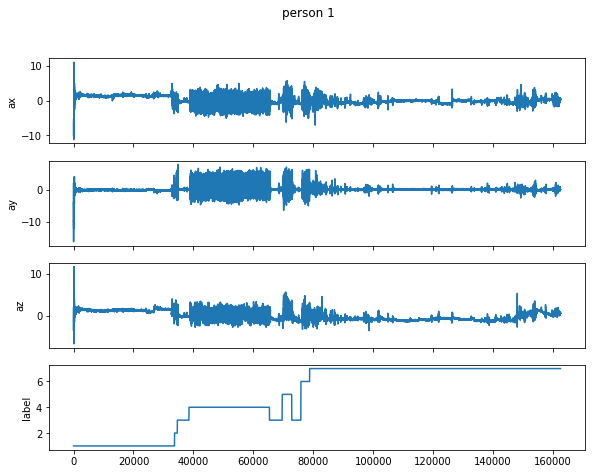

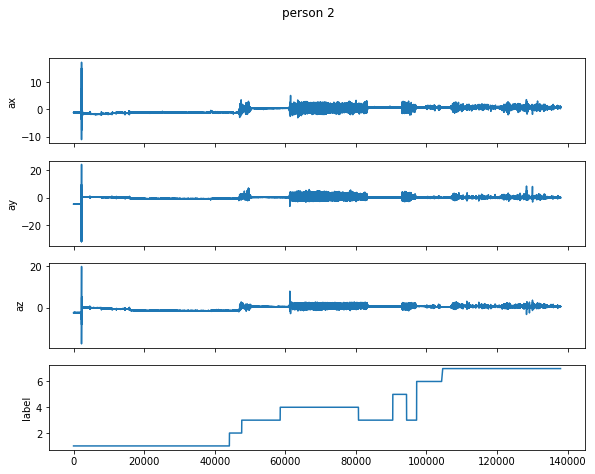

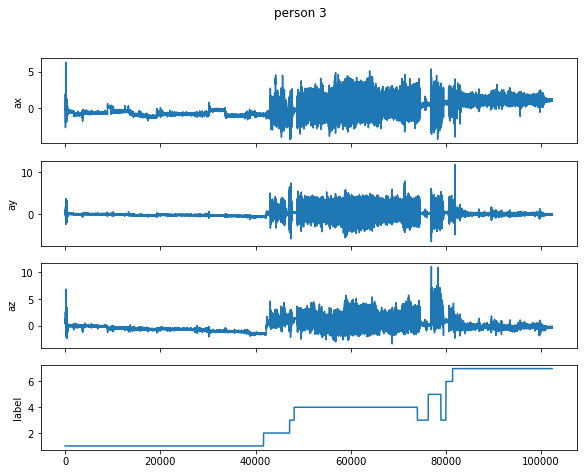

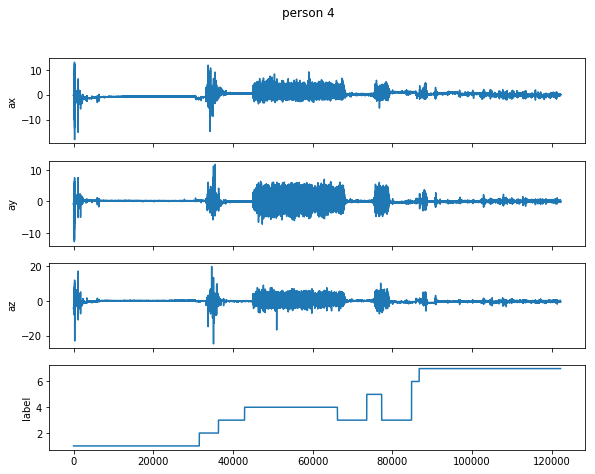

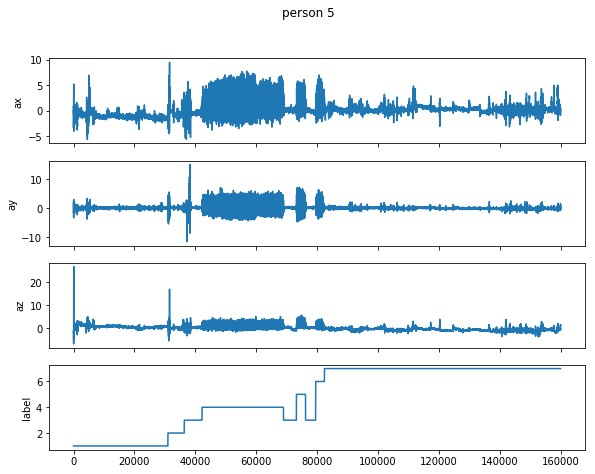

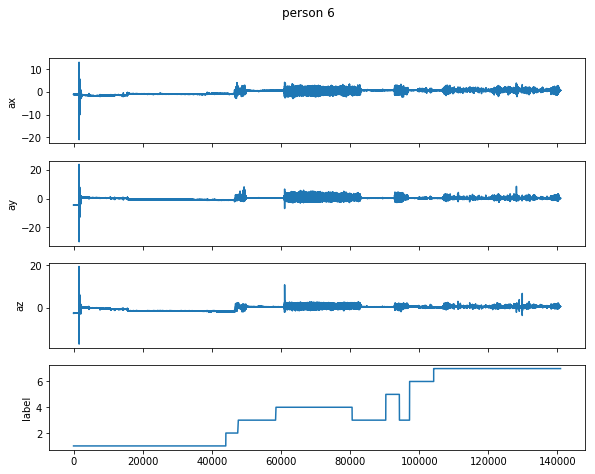

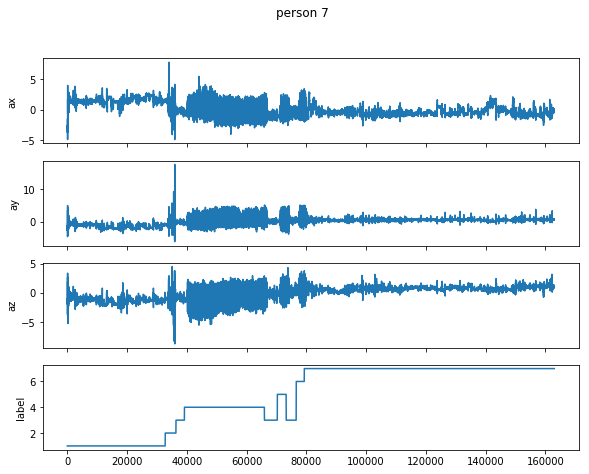

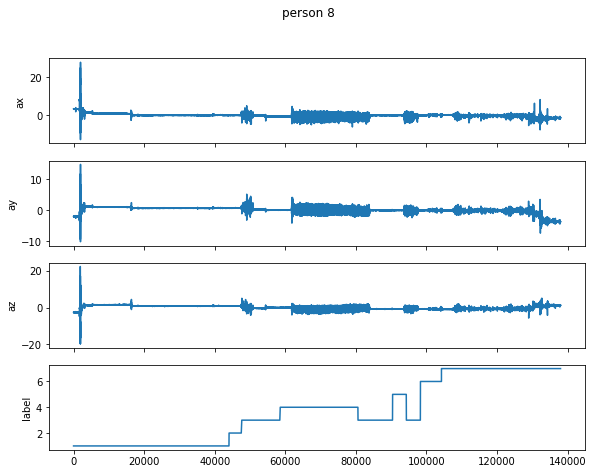

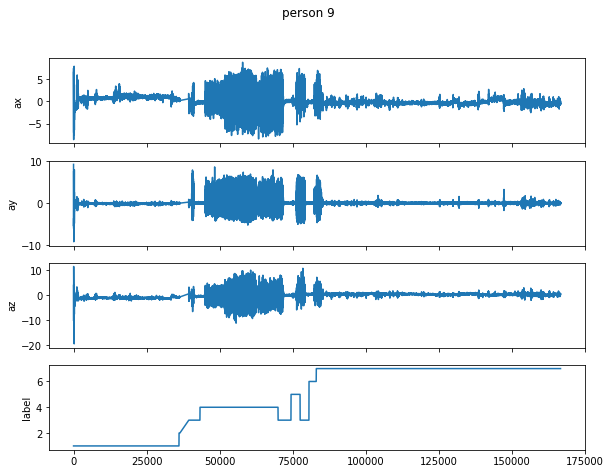

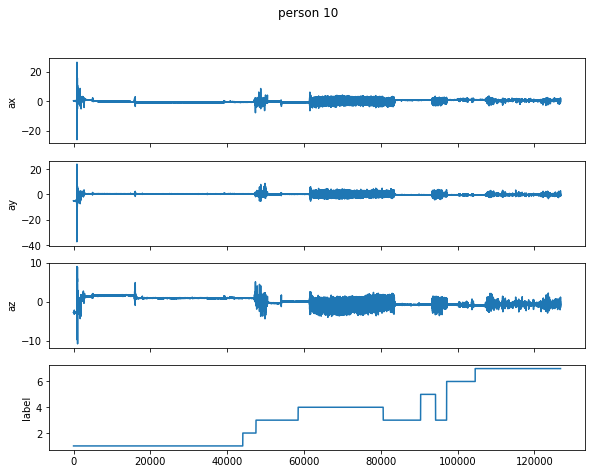

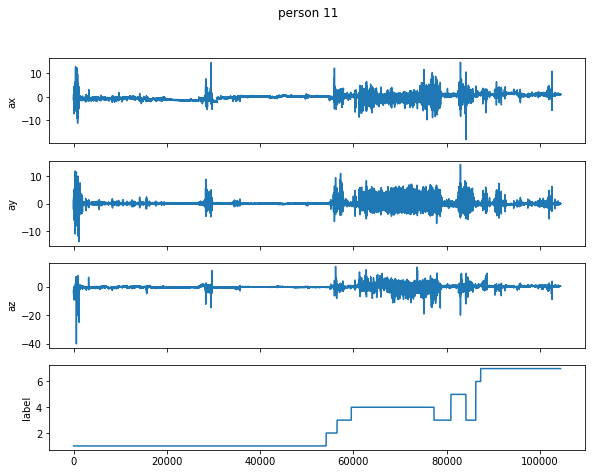

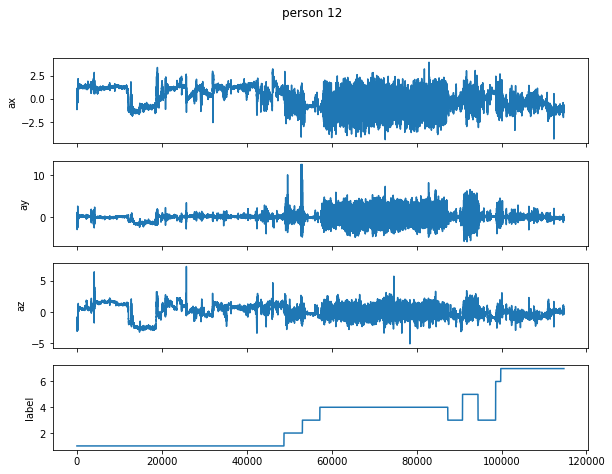

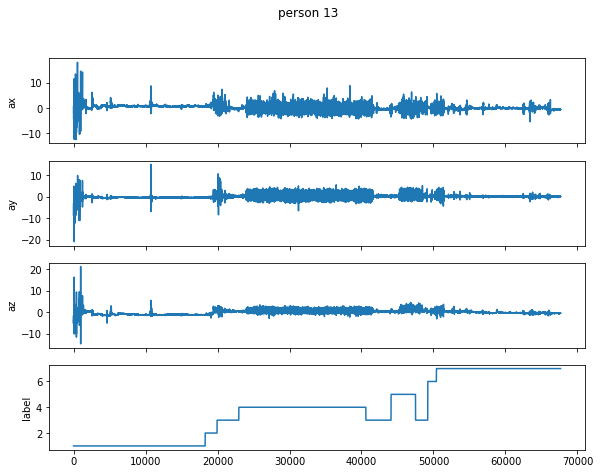

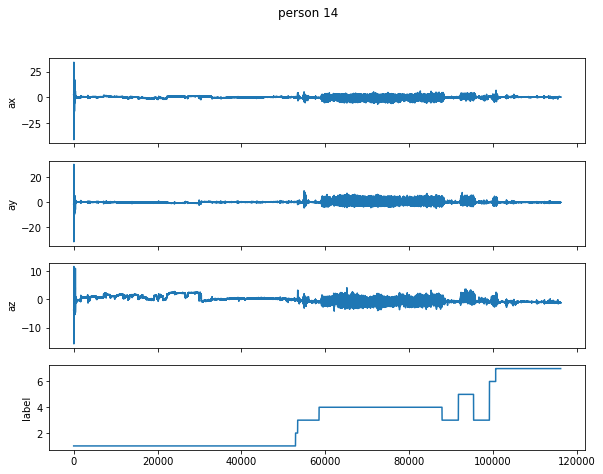

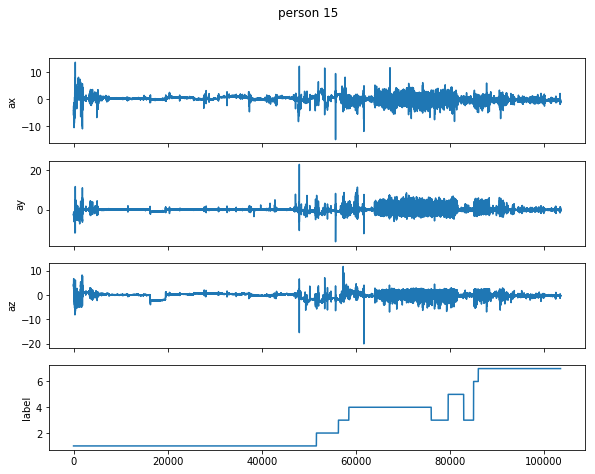

In [10]:
# normalize data
for i in person: 
    for col in ['ax','ay','az']:
        person[i][col] = normalize_data(person[i][col])

plot_data('normalized')

In [11]:
#Add rolling mean
window=52 # 1 sec
for i in person:
    for col in ['ax','ay','az']:
        person[i][col+'_MA'+str(window)] = person[i][col].rolling(window).mean()
        
#Add rolling std
window=52 # 1 sec
for i in person:
    for col in ['ax','ay','az']:
        person[i][col+'_stdA'+str(window)] = person[i][col].rolling(window).std()
        
#Add rolling sum
window=52 # 1 sec
for i in person:
    for col in ['ax','ay','az']:
        person[i][col+'_sumA'+str(window)] = person[i][col].rolling(window).sum()
        
#Add rolling max
window=52 # 1 sec
for i in person:
    for col in ['ax','ay','az']:
        person[i][col+'_maxA'+str(window)] = person[i][col].rolling(window).max()
        
#Add rolling min
window=52 # 1 sec
for i in person:
    for col in ['ax','ay','az']:
        person[i][col+'_minA'+str(window)] = person[i][col].rolling(window).min()

In [12]:
train = pd.DataFrame()
for i in range(1,11):
    train = train.append(person[i])

val = pd.DataFrame()
for i in range(11,13):
    val = val.append(person[i])
    
test = pd.DataFrame()
for i in range(13,16):
    test = test.append(person[i])

In [13]:
x_tr = train.drop(columns='label')
y_tr = train['label']

x_val = val.drop(columns='label')
y_val = val['label']

x_test = test.drop(columns='label')
y_test = test['label']

In [14]:
x_tr = x_tr.fillna(0)
x_val = x_val.fillna(0)
x_test = x_test.fillna(0)

In [15]:
import lightgbm as lgb

evals_result={}

lgb_train = lgb.Dataset(x_tr, label=y_tr)
lgb_test = lgb.Dataset(x_val, label=y_val)

lgb_params = {
               'feature_fraction': .75,
               'metric': 'softmax',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75,#0.75 
               'learning_rate': 0.03, 
               'objective': 'softmax',
               'num_class':8,
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1,
              }

num_boost_round = 50
verbose_eval = num_boost_round/10
lgb_model = lgb.train(lgb_params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['train','eval'],
                  num_boost_round=num_boost_round,
                  evals_result=evals_result,
                  early_stopping_rounds=10,
                  verbose_eval=verbose_eval)

#print ('evals_result = '),evals_result

/anaconda2/envs/activity_recognition/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[50]	train's multi_logloss: 0.63083	eval's multi_logloss: 1.5745


Plot metrics recorded during training...


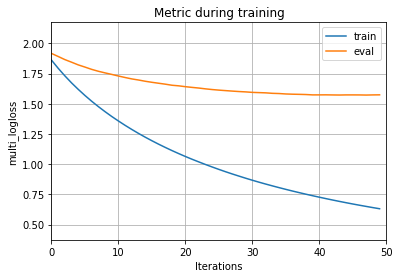

Plot feature importances...


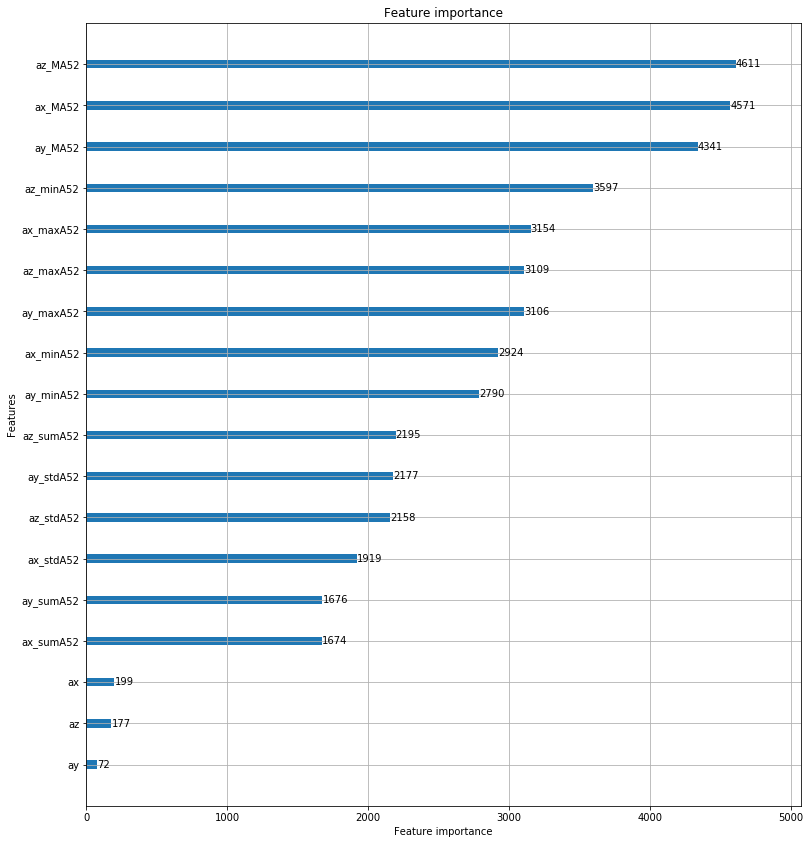

feature importance:
    1 az_MA52 : 4611
    2 ax_MA52 : 4571
    3 ay_MA52 : 4341
    4 az_minA52 : 3597
    5 ax_maxA52 : 3154
    6 az_maxA52 : 3109
    7 ay_maxA52 : 3106
    8 ax_minA52 : 2924
    9 ay_minA52 : 2790
    10 az_sumA52 : 2195
    11 ay_stdA52 : 2177
    12 az_stdA52 : 2158
    13 ax_stdA52 : 1919
    14 ay_sumA52 : 1676
    15 ax_sumA52 : 1674
    16 ax : 199
    17 az : 177
    18 ay : 72


In [16]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='multi_logloss')
# if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(lgb_model, max_num_features=x_val.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
# if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
plt.show()

print ('feature importance:')
sorted_index = np.argsort(lgb_model.feature_importance())
for i in range(len(lgb_model.feature_name())-1,0-1,-1):
    print (' '*3,(len(lgb_model.feature_name())-i), lgb_model.feature_name()[sorted_index[i]],':',lgb_model.feature_importance()[sorted_index[i]])

In [17]:
y_tr_pred = lgb_model.predict(x_tr)
y_val_pred = lgb_model.predict(x_val)
y_test_pred = lgb_model.predict(x_test)

In [18]:
y_test_pred_argmax = np.argmax(y_test_pred, axis=1)
y_test_pred_argmax

array([1, 1, 1, ..., 7, 7, 7])

In [19]:
crosstab = pd.crosstab(y_test.values, y_test_pred_argmax,
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)
crosstab

Predicted,1,2,3,4,5,6,7,All
True,,,,,,,,
1,27313,553,14624,1191,79,4754,74241,122755
2,3064,49,30,346,0,386,2960,6835
3,1525,648,1607,7497,160,46,17432,28915
4,840,625,904,57327,31,2,4746,64475
5,20,280,264,6820,36,0,2900,10320
6,89,163,477,1542,38,11,1381,3701
7,1836,295,4867,4967,222,66,37986,50239
All,34687,2613,22773,79690,566,5265,141646,287240


[Text(0, 0.5, 'Working at Computer'),
 Text(0, 1.5, 'Standing Up, Walking and Going Up/Down stairs'),
 Text(0, 2.5, 'Standing'),
 Text(0, 3.5, 'Walking'),
 Text(0, 4.5, 'Going Up/Down Stairs'),
 Text(0, 5.5, 'Walking and Talking with Someone'),
 Text(0, 6.5, 'Talking while Standing')]

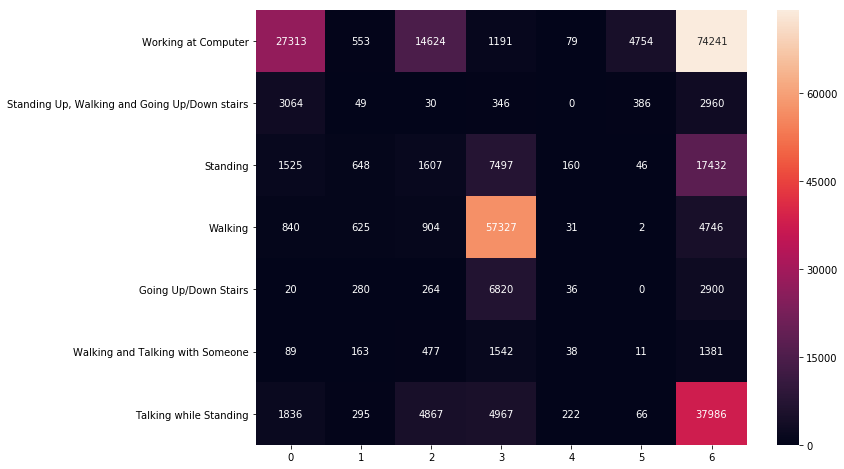

In [20]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.values, y_test_pred_argmax)

class_names = [class_dict[i] for i in range(1,8)]

import seaborn as sns
ax = sns.heatmap(cnf_matrix,annot=True,fmt="d")
ax.figure.set_size_inches(11,8)
# ax.set_xticklabels(class_names,rotation=45)
ax.set_yticklabels(class_names,rotation='horizontal')
